## Environment Setup

### Step 1: Install Required Dependencies

In [1]:
# Install core dependencies
# Run this cell first to install all required packages

!pip install -q \
    langgraph==0.2.28 \
    langchain==0.3.1 \
    langchain-openai==0.2.1 \
    langchain-community==0.3.0 \
    pypdf==4.3.1 \
    pymupdf==1.24.10 \
    python-dotenv==1.0.1 \
    pydantic==2.9.2 \
    opentelemetry-api==1.27.0 \
    opentelemetry-sdk==1.27.0 \
    opentelemetry-instrumentation==0.48b0 \
    opentelemetry-exporter-otlp==1.27.0 \
    prometheus-client==0.21.0 \
    presidio-analyzer==2.2.355 \
    presidio-anonymizer==2.2.355 \
    reportlab==4.2.5

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 2: Configure Environment Variables

Create a `.env` file in the project root with your API keys:

In [ ]:
import os
from pathlib import Path

# Create .env file template if it doesn't exist
env_template = """
# OpenAI Configuration
OPENAI_API_KEY="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
OPENAI_MODEL=gpt-4o-mini

# Azure OpenAI (Alternative - comment out if using OpenAI)
# AZURE_OPENAI_API_KEY=your_azure_key
# AZURE_OPENAI_ENDPOINT=https://your-resource.openai.azure.com/
# AZURE_OPENAI_DEPLOYMENT=gpt-4
# AZURE_OPENAI_API_VERSION=2024-02-15-preview

# Application Settings
LOG_LEVEL=INFO
ENABLE_OBSERVABILITY=true
ENABLE_SECURITY=true

# Observability
OTEL_EXPORTER_OTLP_ENDPOINT=http://localhost:4318
PROMETHEUS_PORT=8000

# Security
RATE_LIMIT_REQUESTS=10
RATE_LIMIT_PERIOD=60
MAX_INPUT_LENGTH=50000
"""

env_path = Path.cwd().parent / ".env"
if not env_path.exists():
    with open(env_path, "w") as f:
        f.write(env_template.strip())
    print(f"✅ Created .env template at {env_path}")
    print("⚠️  Please edit .env file and add your OPENAI_API_KEY")
else:
    print(f"✅ .env file already exists at {env_path}")

✅ .env file already exists at c:\000 - Zensar - AI For Leaders\References\zensar-day6\enterprise-contract-agent\.env


### Step 3: Load Environment and Verify Configuration

In [3]:
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv(override=True)

# Verify critical settings
api_key = os.getenv("OPENAI_API_KEY")

if not api_key:
    print("❌ ERROR: Please set your OPENAI_API_KEY in the .env file")
else:
    print(f"✅ API Key configured (ends with: ...{api_key[-4:]})") 
    print(f"✅ Model: {os.getenv('OPENAI_MODEL', 'gpt-4o-mini')}")
    print(f"✅ Observability: {os.getenv('ENABLE_OBSERVABILITY', 'true')}")
    print(f"✅ Security: {os.getenv('ENABLE_SECURITY', 'true')}")

✅ API Key configured (ends with: ...mWQA)
✅ Model: gpt-4o-mini
✅ Observability: true
✅ Security: true


### Step 4: Generate Sample Contract PDFs

We'll create 5 realistic contract PDFs for testing our agent.

In [ ]:
import sys
import os
from pathlib import Path

# Navigate to sample_contracts directory and generate PDFs
contracts_dir = Path.cwd().parent / "sample_contracts"
os.chdir(contracts_dir)

# Run the PDF generation script
print("Generating sample contract PDFs...\n")
exec(open("generate_sample_pdfs.py", encoding='utf-8').read())

# Return to notebooks directory
os.chdir(Path.cwd().parent / "notebooks")

# List generated files
pdf_files = list(contracts_dir.glob("*.pdf"))
print(f"\n📄 Generated {len(pdf_files)} contract PDFs:")
for pdf in pdf_files:
    size_kb = pdf.stat().st_size / 1024
    print(f"  • {pdf.name} ({size_kb:.1f} KB)")

---

## LangGraph Agent Architecture

Our contract analysis agent follows this workflow:

```
┌─────────────────┐
│  PDF Input      │
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│ Input Validator │ ← Security Layer
│ • PII Detection │
│ • Sanitization  │
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│  Classifier     │ ← Observability
│ • Contract Type │
│ • Complexity    │
└────────┬────────┘
         │
    ┌────┼────┐
    ▼    ▼    ▼
  NDA  SaaS  Empl.
    └────┼────┘
         ▼
┌──────────────────┐
│ Risk Assessment  │ ← Responsible AI
│ • Key Terms      │
│ • Red Flags      │
└────────┬─────────┘
         │
         ▼
┌──────────────────┐
│ Compliance Check │ ← Governance
│ • GDPR Verify    │
│ • Audit Trail    │
└────────┬─────────┘
         │
         ▼
┌──────────────────┐
│ Output Generator │
└──────────────────┘
```

## Define Agent State

The state object carries information through the entire graph workflow.

In [4]:
from typing import TypedDict, List, Optional, Dict, Any
from datetime import datetime

class ContractAnalysisState(TypedDict):
    """State object that flows through the LangGraph workflow."""
    
    # Input data
    contract_text: str
    file_path: Optional[str]
    user_id: str
    request_id: str
    timestamp: str
    
    # Classification
    contract_type: Optional[str]  # NDA, SaaS, Employment, Partnership, Unknown
    complexity: Optional[str]      # Simple, Moderate, Complex
    confidence_score: Optional[float]
    
    # Analysis results
    key_terms: Optional[List[Dict[str, Any]]]
    obligations: Optional[List[str]]
    risks: Optional[List[Dict[str, Any]]]
    red_flags: Optional[List[str]]
    
    # Security
    pii_detected: Optional[bool]
    pii_entities: Optional[List[Dict[str, Any]]]
    sanitized_text: Optional[str]
    security_validated: Optional[bool]
    
    # Compliance
    gdpr_compliant: Optional[bool]
    compliance_issues: Optional[List[str]]
    data_retention_period: Optional[str]
    
    # Observability
    trace_id: Optional[str]
    errors: Optional[List[str]]
    warnings: Optional[List[str]]
    
    # Responsible AI
    explainability: Optional[Dict[str, Any]]
    bias_check: Optional[Dict[str, Any]]
    
    # Final output
    analysis_complete: bool
    final_report: Optional[Dict[str, Any]]


# Example state initialization
def create_initial_state(contract_text: str, file_path: str = None, user_id: str = "demo_user") -> ContractAnalysisState:
    """Create initial state for a contract analysis request."""
    import uuid
    
    return ContractAnalysisState(
        contract_text=contract_text,
        file_path=file_path,
        user_id=user_id,
        request_id=str(uuid.uuid4()),
        timestamp=datetime.utcnow().isoformat(),
        contract_type=None,
        complexity=None,
        confidence_score=None,
        key_terms=None,
        obligations=None,
        risks=None,
        red_flags=None,
        pii_detected=None,
        pii_entities=None,
        sanitized_text=None,
        security_validated=None,
        gdpr_compliant=None,
        compliance_issues=None,
        data_retention_period=None,
        trace_id=None,
        errors=[],
        warnings=[],
        explainability=None,
        bias_check=None,
        analysis_complete=False,
        final_report=None
    )

print("✅ ContractAnalysisState defined")

✅ ContractAnalysisState defined


## PDF Text Extraction Utility

In [5]:
import fitz  # PyMuPDF
from pathlib import Path

def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extract text content from a PDF file using PyMuPDF.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        Extracted text as a string
    """
    try:
        doc = fitz.open(pdf_path)
        text_parts = []
        
        for page_num in range(len(doc)):
            page = doc[page_num]
            text_parts.append(page.get_text())
        
        doc.close()
        full_text = "\n".join(text_parts)
        
        return full_text.strip()
    
    except Exception as e:
        raise ValueError(f"Error extracting text from PDF: {str(e)}")


# Test the extraction function
sample_pdf = Path.cwd().parent / "sample_contracts" / "nda_standard.pdf"
if sample_pdf.exists():
    text = extract_text_from_pdf(str(sample_pdf))
    print(f"✅ Successfully extracted {len(text)} characters from {sample_pdf.name}")
    print(f"\nFirst 300 characters:\n{text[:300]}...")
else:
    print("⚠️  PDF not found. Please generate sample PDFs first.")

✅ Successfully extracted 2874 characters from nda_standard.pdf

First 300 characters:
NON-DISCLOSURE AGREEMENT
This Non-Disclosure Agreement (the "Agreement") is entered into as of November 29, 2025, by and
between:
TechCorp Solutions Inc. ("Disclosing Party"), a corporation organized under the laws of Delaware,
and
InnovateLabs LLC ("Receiving Party"), a limited liability company or...


## Node 1: Contract Classifier

This node analyzes the contract and determines its type and complexity.

In [6]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import json
import os

# Define structured output for classification
class ContractClassification(BaseModel):
    contract_type: str = Field(description="Type of contract: NDA, SaaS, Employment, Partnership, or Unknown")
    complexity: str = Field(description="Complexity level: Simple, Moderate, or Complex")
    confidence_score: float = Field(description="Confidence score between 0 and 1")
    reasoning: str = Field(description="Brief explanation of the classification")


def classify_contract(state: ContractAnalysisState) -> ContractAnalysisState:
    """
    Classify the contract type and complexity using LLM.
    """
    print(f"🔍 Classifying contract (Request ID: {state['request_id']})...")
    
    # Initialize LLM with structured output
    llm = ChatOpenAI(
        model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"),
        temperature=0
    )
    
    structured_llm = llm.with_structured_output(ContractClassification)
    
    # Create classification prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert contract analyst. Analyze the provided contract and classify it.
        
Contract Types:
- NDA: Non-Disclosure Agreement
- SaaS: Software as a Service Agreement  
- Employment: Employment or offer letter
- Partnership: Partnership or joint venture agreement
- Unknown: Cannot determine or mixed type

Complexity Levels:
- Simple: Straightforward, standard terms, <5 pages
- Moderate: Multiple sections, some complexity, 5-15 pages
- Complex: Multi-party, intricate terms, >15 pages or advanced legal structures
"""),
        ("user", "Classify this contract:\n\n{contract_text}")
    ])
    
    # Get classification
    chain = prompt | structured_llm
    
    # Truncate text if too long (first 4000 chars for classification)
    text_sample = state['contract_text'][:4000]
    
    try:
        result = chain.invoke({"contract_text": text_sample})
        
        # Update state
        state['contract_type'] = result.contract_type
        state['complexity'] = result.complexity
        state['confidence_score'] = result.confidence_score
        
        print(f"  ✅ Type: {result.contract_type}")
        print(f"  ✅ Complexity: {result.complexity}")
        print(f"  ✅ Confidence: {result.confidence_score:.2f}")
        print(f"  ℹ️  Reasoning: {result.reasoning}")
        
    except Exception as e:
        state['errors'].append(f"Classification error: {str(e)}")
        state['contract_type'] = "Unknown"
        state['complexity'] = "Unknown"
        state['confidence_score'] = 0.0
        print(f"  ❌ Classification failed: {str(e)}")
    
    return state


# Test the classifier
if sample_pdf.exists():
    test_state = create_initial_state(
        contract_text=extract_text_from_pdf(str(sample_pdf)),
        file_path=str(sample_pdf)
    )
    
    result_state = classify_contract(test_state)
    print(f"\n📊 Classification Result:")
    print(f"   Type: {result_state['contract_type']}")
    print(f"   Complexity: {result_state['complexity']}")
    print(f"   Confidence: {result_state['confidence_score']}")

🔍 Classifying contract (Request ID: 00038be3-df4a-4586-8d9f-f57e91a6f899)...
  ✅ Type: NDA
  ✅ Complexity: Simple
  ✅ Confidence: 0.95
  ℹ️  Reasoning: The contract is a Non-Disclosure Agreement (NDA) with straightforward terms, clearly defining the parties involved, the definition of confidential information, obligations of the receiving party, and other standard clauses. It is concise and under 5 pages, indicating a simple complexity level.

📊 Classification Result:
   Type: NDA
   Complexity: Simple
   Confidence: 0.95


## Node 2: Contract Analyzer

This node performs deep analysis to extract key terms, obligations, and risks.

In [7]:
from typing import List

class KeyTerm(BaseModel):
    term: str = Field(description="The key term or clause")
    description: str = Field(description="What this term means")
    importance: str = Field(description="High, Medium, or Low")


class Risk(BaseModel):
    risk_description: str = Field(description="Description of the risk")
    severity: str = Field(description="High, Medium, or Low")
    mitigation: str = Field(description="How to mitigate this risk")


class ContractAnalysis(BaseModel):
    key_terms: List[KeyTerm] = Field(description="Important terms and clauses")
    obligations: List[str] = Field(description="Key obligations for parties")
    risks: List[Risk] = Field(description="Identified risks")
    red_flags: List[str] = Field(description="Critical issues requiring attention")


def analyze_contract(state: ContractAnalysisState) -> ContractAnalysisState:
    """
    Perform detailed analysis of the contract.
    """
    print(f"\n📝 Analyzing {state['contract_type']} contract...")
    
    llm = ChatOpenAI(
        model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"),
        temperature=0
    )
    
    structured_llm = llm.with_structured_output(ContractAnalysis)
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert contract analyst. Perform a comprehensive analysis of the contract.

Focus on:
1. Key Terms: Important clauses, definitions, and provisions
2. Obligations: What each party must do
3. Risks: Potential issues or unfavorable terms
4. Red Flags: Critical issues that need immediate attention

Be thorough but concise. Prioritize business-critical items.
"""),
        ("user", """Analyze this {contract_type} contract:

{contract_text}

Provide a structured analysis.""")
    ])
    
    chain = prompt | structured_llm
    
    try:
        result = chain.invoke({
            "contract_type": state['contract_type'],
            "contract_text": state['contract_text'][:15000]  # Limit for token efficiency
        })
        
        # Convert to dicts for state storage
        state['key_terms'] = [term.dict() for term in result.key_terms]
        state['obligations'] = result.obligations
        state['risks'] = [risk.dict() for risk in result.risks]
        state['red_flags'] = result.red_flags
        
        print(f"  ✅ Found {len(result.key_terms)} key terms")
        print(f"  ✅ Found {len(result.obligations)} obligations")
        print(f"  ✅ Identified {len(result.risks)} risks")
        print(f"  ⚠️  {len(result.red_flags)} red flags detected")
        
        if result.red_flags:
            print("\n  🚨 Red Flags:")
            for flag in result.red_flags[:3]:  # Show first 3
                print(f"     • {flag}")
        
    except Exception as e:
        state['errors'].append(f"Analysis error: {str(e)}")
        print(f"  ❌ Analysis failed: {str(e)}")
    
    return state


# Test the analyzer
if result_state['contract_type'] != "Unknown":
    analyzed_state = analyze_contract(result_state)
    
    print("\n📊 Analysis Summary:")
    if analyzed_state['key_terms']:
        print(f"\n  Top Key Terms:")
        for term in analyzed_state['key_terms'][:2]:
            print(f"    • {term['term']} ({term['importance']} importance)")
            print(f"      {term['description']}")


📝 Analyzing NDA contract...
  ✅ Found 6 key terms
  ✅ Found 4 obligations
  ✅ Identified 3 risks
  ⚠️  3 red flags detected

  🚨 Red Flags:
     • Lack of specific penalties for breach of confidentiality
     • No definition of what constitutes 'reasonable care' in protecting confidential information
     • Absence of a clause addressing the handling of information after the term ends

📊 Analysis Summary:

  Top Key Terms:
    • Confidential Information (High importance)
      Any proprietary data or information not generally known to the public, including technical data, trade secrets, business information, etc.
    • Obligations of Receiving Party (High importance)
      The responsibilities of the Receiving Party to maintain confidentiality, restrict use, and protect the information.


## Building the Complete LangGraph

Now let's connect all nodes into a graph workflow.

In [8]:
from langgraph.graph import StateGraph, END

def create_contract_analysis_graph():
    """
    Create the LangGraph workflow for contract analysis.
    """
    # Initialize graph
    workflow = StateGraph(ContractAnalysisState)
    
    # Add nodes
    workflow.add_node("classify", classify_contract)
    workflow.add_node("analyze", analyze_contract)
    
    # Simple placeholder for now - we'll add more nodes in later parts
    def finalize_output(state: ContractAnalysisState) -> ContractAnalysisState:
        """Generate final report."""
        print("\n📄 Generating final report...")
        
        state['final_report'] = {
            "request_id": state['request_id'],
            "timestamp": state['timestamp'],
            "contract_type": state['contract_type'],
            "complexity": state['complexity'],
            "confidence": state['confidence_score'],
            "summary": {
                "key_terms_count": len(state['key_terms']) if state['key_terms'] else 0,
                "obligations_count": len(state['obligations']) if state['obligations'] else 0,
                "risks_count": len(state['risks']) if state['risks'] else 0,
                "red_flags_count": len(state['red_flags']) if state['red_flags'] else 0
            },
            "details": {
                "key_terms": state['key_terms'],
                "obligations": state['obligations'],
                "risks": state['risks'],
                "red_flags": state['red_flags']
            }
        }
        
        state['analysis_complete'] = True
        print("  ✅ Report generated successfully")
        
        return state
    
    workflow.add_node("finalize", finalize_output)
    
    # Define edges (workflow sequence)
    workflow.set_entry_point("classify")
    workflow.add_edge("classify", "analyze")
    workflow.add_edge("analyze", "finalize")
    workflow.add_edge("finalize", END)
    
    # Compile the graph
    app = workflow.compile()
    
    return app


# Create the graph
contract_agent = create_contract_analysis_graph()
print("✅ LangGraph workflow created successfully!")

✅ LangGraph workflow created successfully!


## Visualize the Graph

Let's visualize the LangGraph workflow to see how the nodes are connected.

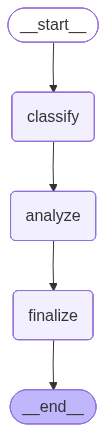

Graph visualization displayed above


In [9]:
from IPython.display import Image, display

try:
    # Generate the graph visualization
    graph_image = contract_agent.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("Graph visualization displayed above")
except Exception as e:
    # Fallback to ASCII representation
    print("Graph Structure (ASCII):")
    print("=" * 60)
    print(contract_agent.get_graph().draw_ascii())
    print("=" * 60)
    print(f"\nNote: Install graphviz for better visualization: pip install graphviz")

## Run Complete Analysis

Let's test the full workflow on a sample contract.

In [10]:
import json
from pathlib import Path

# Select a contract to analyze
test_contract_path = Path.cwd().parent / "sample_contracts" / "saas_agreement.pdf"

if test_contract_path.exists():
    print(f"📄 Analyzing: {test_contract_path.name}")
    print("=" * 80)
    
    # Extract text
    contract_text = extract_text_from_pdf(str(test_contract_path))
    
    # Create initial state
    initial_state = create_initial_state(
        contract_text=contract_text,
        file_path=str(test_contract_path),
        user_id="demo_user_001"
    )
    
    # Run the agent
    final_state = contract_agent.invoke(initial_state)
    
    # Display results
    print("\n" + "=" * 80)
    print("📊 FINAL ANALYSIS REPORT")
    print("=" * 80)
    
    report = final_state['final_report']
    
    print(f"\n🔍 Contract Information:")
    print(f"   Type: {report['contract_type']}")
    print(f"   Complexity: {report['complexity']}")
    print(f"   Confidence: {report['confidence']:.2%}")
    
    print(f"\n📈 Summary:")
    print(f"   Key Terms: {report['summary']['key_terms_count']}")
    print(f"   Obligations: {report['summary']['obligations_count']}")
    print(f"   Risks: {report['summary']['risks_count']}")
    print(f"   Red Flags: {report['summary']['red_flags_count']}")
    
    # Show sample details
    if report['details']['red_flags']:
        print(f"\n🚨 Red Flags:")
        for i, flag in enumerate(report['details']['red_flags'][:3], 1):
            print(f"   {i}. {flag}")
    
    if report['details']['risks']:
        print(f"\n⚠️  Top Risks:")
        for i, risk in enumerate(report['details']['risks'][:2], 1):
            print(f"   {i}. {risk['risk_description']} (Severity: {risk['severity']})")
            print(f"      Mitigation: {risk['mitigation']}")
    
    # Save report to file
    output_dir = Path.cwd().parent / "output"
    output_dir.mkdir(exist_ok=True)
    
    report_file = output_dir / f"analysis_{final_state['request_id']}.json"
    with open(report_file, 'w') as f:
        json.dump(final_state['final_report'], f, indent=2)
    
    print(f"\n💾 Full report saved to: {report_file}")
    
else:
    print("❌ Test contract not found. Please generate sample PDFs first.")

📄 Analyzing: saas_agreement.pdf
🔍 Classifying contract (Request ID: 0a2f7b22-1bbd-47b7-b0aa-53c68347652c)...
  ✅ Type: SaaS
  ✅ Complexity: Moderate
  ✅ Confidence: 0.95
  ℹ️  Reasoning: The contract is a Software as a Service Agreement detailing the services provided, subscription plans, pricing, service level agreements, data security, intellectual property rights, and terms of termination. It contains multiple sections and is moderately complex, fitting within the 5-15 pages range.

📝 Analyzing SaaS contract...
  ✅ Found 9 key terms
  ✅ Found 2 obligations
  ✅ Identified 4 risks
  ⚠️  3 red flags detected

  🚨 Red Flags:
     • Limitation of liability clause may expose Customer to significant risk.
     • Automatic renewal clause could lead to unexpected costs.
     • Data retention policy post-termination may result in loss of important data.

📄 Generating final report...
  ✅ Report generated successfully

📊 FINAL ANALYSIS REPORT

🔍 Contract Information:
   Type: SaaS
   Complexity

## Summary - Part 1

### What We've Accomplished:

**Environment Setup**
- Installed all required dependencies
- Configured environment variables
- Generated 5 realistic contract PDFs

**LangGraph Agent Built**
- Defined comprehensive state management
- Created contract classifier node
- Created contract analyzer node
- Connected nodes into complete workflow

**Core Functionality Working**
- PDF text extraction
- Contract type classification (NDA, SaaS, Employment, Partnership)
- Key terms and obligations extraction
- Risk assessment and red flag detection

---
